In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests
from time import time

#data processing libraries 

from sklearn import preprocessing

import nltk
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings
import re
warnings.filterwarnings('ignore')




#Evaluate the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score



In [77]:
#pip install tensorflow

In [275]:
def get_page(url):
    page = requests.get(url)
    soup = bs(page.text,"lxml")
    return soup

In [276]:
def get_links(soup):
    links=[]
    listings = soup.find_all('a' ,{'class' : 'bookTitle'})
    base_url="https://www.goodreads.com"
    for i in listings:
        book_link = i.get("href")
        complete_link  = base_url + book_link
        links.append(complete_link)
    return links

In [277]:
#extract info from each link

def extract_info(links):
    for link in links:
        res = requests.get(link).text
        book_soup = bs(res,'html.parser')
        try:
            book_id = book_soup.find('div',{'id':'buyButtonContainer'}).get('data-book-id')
            title = book_soup.find('h1',{'id':"bookTitle"}).text.strip()
            author = book_soup.find('span',{'itemprop':"name"}).text.strip()
            average_rating = book_soup.find('span',{'itemprop':"ratingValue"}).text.strip()
            #description = book_soup.find('div',{'id':"description"}).text.strip()
            description = book_soup.find('div', {'id': "description"}).find_all('span')[-1].text.strip()
            genre = book_soup.find('a',{'class':"actionLinkLite bookPageGenreLink"}).text.strip()
            book_image_url = book_soup.find('img', {'id': 'coverImage'}).get('src').strip()
            book_url = link
        except AttributeError:
            continue
        
        book = {'book_id':book_id,'title': title,'author': author,'average_rating':average_rating,'genre':genre,'description':description,'url':book_url,'image_url':book_image_url}
        all_books.append(book)
    return len(all_books)


In [75]:
all_books = []
books  = pd.DataFrame()
for page in range(1,51):
    url = "https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once?page={}".format(page)
    soup = get_page(url)
    links = get_links(soup)
    (extract_info(links))


KeyboardInterrupt: 

In [ ]:
books = pd.DataFrame(all_books)

In [ ]:
books.to_csv('books_data_50_b.csv')

In [2]:
books = pd.read_csv('books_data_50_b.csv')
books.drop('Unnamed: 0',axis = 1,inplace = True)

In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6585 entries, 0 to 6584
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   book_id         6585 non-null   int64  
 1   title           6585 non-null   object 
 2   author          6585 non-null   object 
 3   average_rating  6585 non-null   float64
 4   genre           6585 non-null   object 
 5   description     6584 non-null   object 
 6   url             6585 non-null   object 
 7   image_url       6585 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 411.7+ KB


In [4]:
#shape of the final dataframe
books.shape

(6585, 8)

## EDA

In [5]:
#checking null values
books.isnull().sum()

book_id           0
title             0
author            0
average_rating    0
genre             0
description       1
url               0
image_url         0
dtype: int64

In [6]:
is_NaN = books.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = books[row_has_NaN]
rows_with_NaN


,book_id,title,author,average_rating,genre,description,url,image_url
6567,117531,Dark Night of the Soul,John of the Cross,4.1,Religion,NaN,https://www.goodreads.com/book/show/117531.Dar...,https://i.gr-assets.com/images/S/compressed.ph...


In [7]:
books  = books.drop(6567)


In [8]:
books.isnull().sum()


book_id           0
title             0
author            0
average_rating    0
genre             0
description       0
url               0
image_url         0
dtype: int64

In [9]:
#checking duplicate rows
books.duplicated().sum()

0

In [10]:
#dropping duplicates
books.drop_duplicates(keep = 'first',inplace = True)

In [11]:
#check value count by genre
books.genre.value_counts()

Fiction         1372
Fantasy          734
Nonfiction       678
Classics         425
Young Adult      340
                ... 
Writing            1
Gothic             1
Audiobook          1
Games              1
Anthropology       1
Name: genre, Length: 101, dtype: int64

### Distribution of data by Genre

<AxesSubplot:>

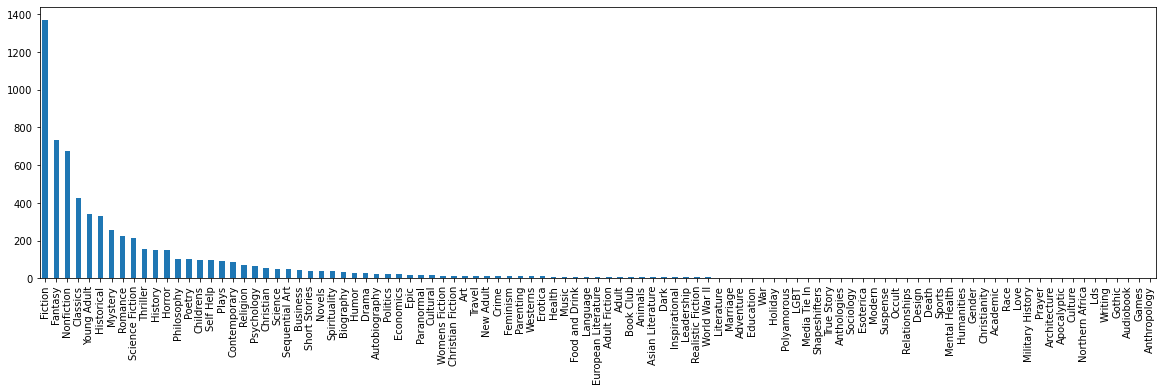

In [12]:
books['genre'].value_counts().plot(x='genre',y = 'count',kind = 'bar',figsize = (20,5))

The data is quite unbalanced. we will consider the first six categories for the final analysis.

In [13]:
#print the title and description of a random sample

books.duplicated().sum()

0

<Figure size 864x720 with 0 Axes>

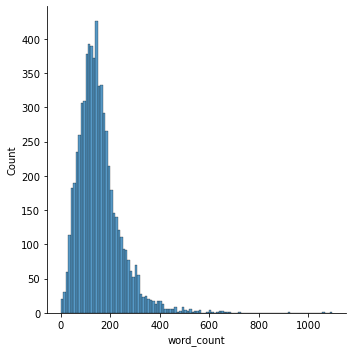

In [14]:
#Calculating the word count for book description and adding a new column to the dataframe

import seaborn as sns
import matplotlib.pyplot as plt

books['word_count'] = books['description'].apply(lambda x: len(str(x).split()))  # Plotting the word count
plt.figure(figsize=[12, 10])
sns.displot(books['word_count'])


The book descriptions are not too leangthy. Average length of book descriptions are mostly of 200 words.

In [15]:
books.head()

,book_id,title,author,average_rating,genre,description,url,image_url,word_count
0,2657,To Kill a Mockingbird,Harper Lee,4.27,Classics,The unforgettable novel of a childhood in a sl...,https://www.goodreads.com/book/show/2657.To_Ki...,https://i.gr-assets.com/images/S/compressed.ph...,137
1,3,Harry Potter and the Sorcerer's Stone,J.K. Rowling,4.47,Fantasy,Harry Potter's life is miserable. His parents ...,https://www.goodreads.com/book/show/3.Harry_Po...,https://i.gr-assets.com/images/S/compressed.ph...,220
2,1885,Pride and Prejudice,Jane Austen,4.27,Classics,Alternate cover edition of ISBN 9780679783268S...,https://www.goodreads.com/book/show/1885.Pride...,https://i.gr-assets.com/images/S/compressed.ph...,100
3,48855,The Diary of a Young Girl,Anne Frank,4.17,Nonfiction,Discovered in the attic in which she spent the...,https://www.goodreads.com/book/show/48855.The_...,https://i.gr-assets.com/images/S/compressed.ph...,166
4,170448,Animal Farm,George Orwell,3.97,Classics,Librarian's note: There is an Alternate Cover ...,https://www.goodreads.com/book/show/170448.Ani...,https://i.gr-assets.com/images/S/compressed.ph...,123


## Data Preprocessing

In [16]:
books['genre'].unique()

array(['Classics', 'Fantasy', 'Nonfiction', 'Historical', 'Fiction',
       'Young Adult', 'Childrens', 'Science Fiction', 'Poetry', 'Horror',
       'Religion', 'History', 'Mystery', 'Travel', 'Romance',
       'Philosophy', 'Thriller', 'Sequential Art', 'Academic', 'Science',
       'Self Help', 'Language', 'Plays', 'Christian', 'Contemporary',
       'Drama', 'Autobiography', 'Esoterica', 'Short Stories', 'Crime',
       'Psychology', 'Feminism', 'Christian Fiction', 'Biography',
       'Business', 'Novels', 'Paranormal', 'Apocalyptic', 'Inspirational',
       'Economics', 'Spirituality', 'Epic', 'Book Club', 'Marriage',
       'Education', 'Humor', 'Art', 'Politics', 'Polyamorous',
       'Womens Fiction', 'Health', 'New Adult', 'Erotica',
       'Shapeshifters', 'War', 'Design', 'Cultural', 'Adult', 'Parenting',
       'Realistic Fiction', 'Gender', 'Gothic', 'Animals', 'LGBT',
       'Modern', 'Literature', 'Music', 'Dark', 'Leadership', 'Adventure',
       'Suspense', 'Westerns'

In [17]:
#filtering #1  books with genres consiting more than 100 books
df = books[books['genre'].map(books['genre'].value_counts()) > 100]

In [18]:
df['genre'].value_counts()

Fiction            1372
Fantasy             734
Nonfiction          678
Classics            425
Young Adult         340
Historical          331
Mystery             257
Romance             223
Science Fiction     213
Thriller            156
History             151
Horror              150
Philosophy          104
Poetry              101
Name: genre, dtype: int64

In [19]:
# creating a sub dataframe of fiction books with  less than 160 word count.
# As description is our main criteria for model accuracy and prediction , we are removing the books which has low word count.
df2 = df[(df.genre == 'Fiction') & (df.word_count <= 160)]
# dropping the  rows created in df2 from the df column.
df.drop(df2.index,axis=0,inplace=True)

In [20]:
df.genre.value_counts()
# Updated genre count.

Fantasy            734
Nonfiction         678
Fiction            499
Classics           425
Young Adult        340
Historical         331
Mystery            257
Romance            223
Science Fiction    213
Thriller           156
History            151
Horror             150
Philosophy         104
Poetry             101
Name: genre, dtype: int64

array([<AxesSubplot:ylabel='genre'>], dtype=object)

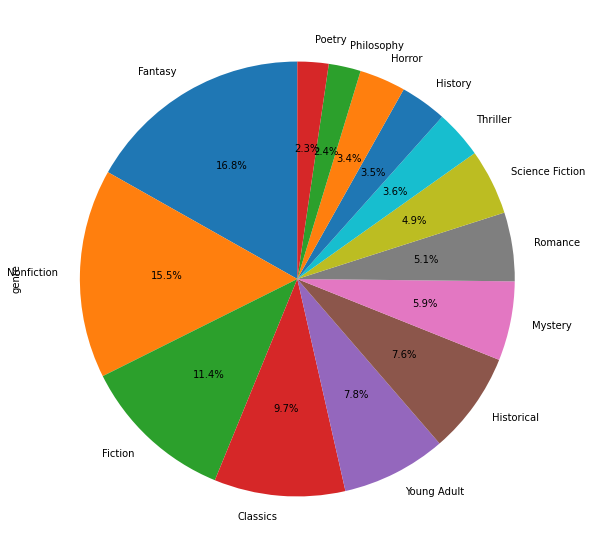

In [21]:
df.genre.value_counts().plot(kind='pie', subplots=True, startangle=90,
figsize=(15,10), autopct='%1.1f%%')

In [22]:
# Label encoding the Class column : Abusive = 0 and Non Abusive = 1

le = preprocessing.LabelEncoder()
le_fit = le.fit_transform(df.genre)
df['genre_le'] = le.fit_transform(df.genre)


In [23]:
le_fit

array([ 0,  1,  0, ...,  0, 13,  4])

In [24]:
df['author'] = df['author'].str.replace(" ","")
df['tags'] = df['author'] + " " + df['title'] + " " + df['description']
df.drop(['word_count', 'author', 'description'], axis=1, inplace=True)



In [25]:
#text cleaning,lowercase,removing special characters and stemming words. Note: We are handling stopwords directly using CountVectorizer's inbuilt stop_words functions.
#stemming
ps = PorterStemmer()
def clean_summary(text):
    # removing everything other than alphabets and numbers with spaces
    text = re.sub('\W+', ' ', text)
    text = text.lower()  # converts all the text to lowercase
    #stemming words now.
    y = []
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)


In [26]:
df['tags'] = df['tags'].apply(clean_summary)
df.sample(10)


,book_id,title,average_rating,genre,url,image_url,genre_le,tags
4774,29875363,The Fireman,3.91,Horror,https://www.goodreads.com/book/show/29875363-t...,https://i.gr-assets.com/images/S/compressed.ph...,5,joehil the fireman from the award win new york...
6262,32638,The Thief of Always,4.20,Fantasy,https://www.goodreads.com/book/show/32638.The_...,https://i.gr-assets.com/images/S/compressed.ph...,1,clivebark the thief of alway master storytel a...
5186,91475,White Night,4.37,Fantasy,https://www.goodreads.com/book/show/91475.Whit...,https://i.gr-assets.com/images/S/compressed.ph...,1,jimbutch white night wizard harri dresden must...
5105,788331,"He, She and It",3.98,Science Fiction,https://www.goodreads.com/book/show/788331.He_...,https://i.gr-assets.com/images/S/compressed.ph...,11,margepierci he she and it in the middl of the ...
4130,898885,Loving Frank,3.75,Historical,https://www.goodreads.com/book/show/898885.Lov...,https://i.gr-assets.com/images/S/compressed.ph...,3,nancyhoran love frank i have been stand on the...
3650,77449,Here Be Dragons,4.26,Historical,https://www.goodreads.com/book/show/77449.Here...,https://i.gr-assets.com/images/S/compressed.ph...,3,sharonkaypenman here be dragon thirteenth cent...
3976,9409469,The Gray Wolf Throne,4.38,Fantasy,https://www.goodreads.com/book/show/9409469-th...,https://i.gr-assets.com/images/S/compressed.ph...,1,cindawilliamschima the gray wolf throne han al...
1242,82970,Lucky,3.77,Nonfiction,https://www.goodreads.com/book/show/82970.Lucky,https://i.gr-assets.com/images/S/compressed.ph...,7,alicesebold lucki in a memoir hail for it sear...
4950,6452731,Justice: What's the Right Thing to Do?,4.31,Philosophy,https://www.goodreads.com/book/show/6452731-ju...,https://i.gr-assets.com/images/S/compressed.ph...,8,michaelj sandel justic what s the right thing ...
3018,1421990,Halfway to the Grave,4.12,Fantasy,https://www.goodreads.com/book/show/1421990.Ha...,https://i.gr-assets.com/images/S/compressed.ph...,1,jeanienefrost halfway to the grave flirt with ...


In [27]:
# assign the independent features (text) to X variable and the target to y
X = pd.DataFrame(df['tags'])
y = df['genre_le']


In [28]:
y

0        0
1        1
2        0
3        7
4        0
        ..
6579     0
6580     1
6582     0
6583    13
6584     4
Name: genre_le, Length: 4362, dtype: int64

In [29]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [30]:
y.value_counts()

1     734
7     678
2     499
0     425
13    340
3     331
6     257
10    223
11    213
12    156
4     151
5     150
8     104
9     101
Name: genre_le, dtype: int64

In [31]:
#performing oversampling on most genres.
strategy = {0:500, 1:734, 2:500, 3:500, 4:500, 5:500,6:500,7:678,8:500,9:500,10:500,11:500,12:500,13:500}
os = RandomOverSampler(sampling_strategy = strategy)

In [32]:
X_rs, y_rs = os.fit_resample(X,y)

In [33]:
from collections import Counter
print(Counter(y))


Counter({1: 734, 7: 678, 2: 499, 0: 425, 13: 340, 3: 331, 6: 257, 10: 223, 11: 213, 12: 156, 4: 151, 5: 150, 8: 104, 9: 101})


In [34]:
print(Counter(y_rs))

Counter({1: 734, 7: 678, 0: 500, 3: 500, 13: 500, 11: 500, 9: 500, 2: 500, 5: 500, 4: 500, 6: 500, 10: 500, 8: 500, 12: 500})


In [35]:
#performing undersampling on class 2
strategy = {0:500, 1:500, 2:500, 3:500, 4:500, 5:500,6:500,7:500,8:500,9:500,10:500,11:500,12:500,13:500}
us = RandomUnderSampler(sampling_strategy = strategy)

In [36]:
X_new, y_new = us.fit_resample(X_rs,y_rs)

In [37]:
print(Counter(y_new))

Counter({0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500, 10: 500, 11: 500, 12: 500, 13: 500})


<AxesSubplot:>

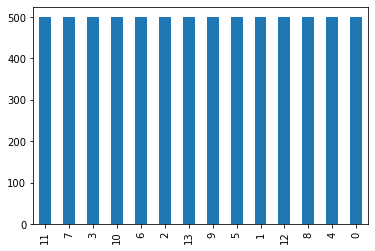

In [38]:
y_new.value_counts().plot(x='y_new',y = 'count',kind = 'bar')

In [39]:
y_new.shape

(7000,)

## Split the dataset into Train and Test sets

In [40]:
#split data into training 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.20)

In [41]:
X_train.head()

,tags
2343,thucydid histori of the peloponnesian war writ...
6327,s k tremayn the ice twin a year after one of t...
3908,billbryson shakespear the world as stage at fi...
5851,olafstapledon star maker star maker is a scien...
1456,bethhoffman save ceece honeycutt twelv year ol...


In [42]:
x_train = X_train.iloc[:,0]
x_train.head()

2343    thucydid histori of the peloponnesian war writ...
6327    s k tremayn the ice twin a year after one of t...
3908    billbryson shakespear the world as stage at fi...
5851    olafstapledon star maker star maker is a scien...
1456    bethhoffman save ceece honeycutt twelv year ol...
Name: tags, dtype: object

## CountVectorizer - Feature Extraction

In [43]:
#using countvectorizer and setting max features and handling stopwords.
cv = CountVectorizer(max_features = 10000,stop_words = 'english')

In [44]:
x = cv.fit_transform(x_train).toarray()
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [45]:
x_test = X_test.iloc[:,0]
x_test.head()

559     shannonmesseng everblaz a new york time bestse...
712     orsonscottcard songmast an sf classic from the...
6476    lincolnchild deep storm twelv thousand feet be...
6104    stevenkonkoli the rescu former cia oper turn m...
2894    kilongfellow houdini heart houdini heart harke...
Name: tags, dtype: object

In [46]:
test_x = cv.transform(x_test).toarray()
test_x.shape

(1400, 10000)

## Model Fitting

In [47]:
# Creating empty lists to store model training time, model predicting time, model accuracy scores, model precision scores.
training_time = []
predicting_time = []
accuracy_scores = []
train_accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

In [48]:
model1 = MultinomialNB()

In [49]:
#train model and predict model training time
t0 = time()
model1.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 6.811 s



In [50]:
# Predict using the trained model on test data.
t1 = time()
predicted = model1.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))

# predicting train data.
train_pred1 = model1.predict(x)
print('\nAccuracy Score for training data: ',accuracy_score(y_train,train_pred1))
train_accuracy_scores.append(accuracy_score(y_train,train_pred1))

Predicting time: 0.123 s


Accuracy Score for training data:  0.9642857142857143


In [51]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))




Accuracy Score 0.825
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.66      0.68        94
           1       0.80      0.74      0.77       107
           2       0.54      0.56      0.55       108
           3       0.77      0.78      0.77        95
           4       0.87      0.95      0.91       102
           5       0.92      0.96      0.94        89
           6       0.86      0.80      0.83        97
           7       0.86      0.74      0.80        97
           8       0.93      0.95      0.94       102
           9       0.97      0.96      0.96        94
          10       0.84      0.94      0.88        94
          11       0.97      0.89      0.93       102
          12       0.88      0.89      0.88       112
          13       0.70      0.77      0.73       107

    accuracy                           0.82      1400
   macro avg       0.83      0.83      0.83      1400
weighted avg       0.83      0.82 

In [52]:
model2 = GaussianNB()

In [53]:
#train model and predict model training time
t0 = time()
model2.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 0.928 s



In [54]:
# Predit using the trained model
t1 = time()
predicted = model2.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))
# predicting train data.
train_pred2 = model2.predict(x)
print('\nAccuracy Score for training data: ',accuracy_score(y_train,train_pred1))
train_accuracy_scores.append(accuracy_score(y_train,train_pred2))

Predicting time: 1.263 s


Accuracy Score for training data:  0.9642857142857143


In [55]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))



Accuracy Score 0.7721428571428571
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.48      0.56        94
           1       0.71      0.44      0.54       107
           2       0.30      0.65      0.41       108
           3       0.77      0.63      0.69        95
           4       0.94      0.96      0.95       102
           5       0.95      0.94      0.95        89
           6       0.88      0.78      0.83        97
           7       0.55      0.60      0.57        97
           8       0.99      1.00      1.00       102
           9       0.98      0.99      0.98        94
          10       0.91      0.90      0.91        94
          11       0.94      0.96      0.95       102
          12       0.96      0.88      0.92       112
          13       0.88      0.62      0.73       107

    accuracy                           0.77      1400
   macro avg       0.82      0.77      0.79      1400
weighted avg       0.

In [56]:
model3 = tree.DecisionTreeClassifier()

In [57]:
#train model and predict model training time
t0 = time()
model3.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 17.045 s



In [58]:
# Predit using the trained model
t1 = time()
predicted = model3.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))

# predicting train data.
train_pred3 = model3.predict(x)
print('\nAccuracy Score for training data: ',accuracy_score(y_train,train_pred1))
train_accuracy_scores.append(accuracy_score(y_train,train_pred3))

Predicting time: 0.066 s


Accuracy Score for training data:  0.9642857142857143


In [59]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))



Accuracy Score 0.7107142857142857
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.39      0.44        94
           1       0.49      0.44      0.46       107
           2       0.24      0.13      0.17       108
           3       0.50      0.62      0.56        95
           4       0.83      0.97      0.90       102
           5       0.91      0.96      0.93        89
           6       0.73      0.86      0.79        97
           7       0.51      0.36      0.42        97
           8       0.94      1.00      0.97       102
           9       0.94      1.00      0.97        94
          10       0.73      0.87      0.79        94
          11       0.79      0.94      0.86       102
          12       0.88      0.90      0.89       112
          13       0.59      0.57      0.58       107

    accuracy                           0.71      1400
   macro avg       0.69      0.72      0.70      1400
weighted avg       0.

In [60]:
model5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

In [61]:
#train model and predict model training time
t0 = time()
model5.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 0.002 s



In [62]:
# Predit using the trained model
t1 = time()
predicted = model5.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))

# predicting train data.
train_pred5 = model5.predict(x)
print('\nAccuracy Score for training data: ',accuracy_score(y_train,train_pred1))
train_accuracy_scores.append(accuracy_score(y_train,train_pred5))

Predicting time: 1.432 s


Accuracy Score for training data:  0.9642857142857143


In [63]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))



Accuracy Score 0.36857142857142855
Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.79      0.18        94
           1       0.62      0.07      0.13       107
           2       0.50      0.01      0.02       108
           3       0.48      0.22      0.30        95
           4       0.79      0.58      0.67       102
           5       0.49      0.54      0.52        89
           6       0.90      0.19      0.31        97
           7       1.00      0.03      0.06        97
           8       0.68      0.78      0.73       102
           9       0.81      0.84      0.83        94
          10       0.61      0.30      0.40        94
          11       0.84      0.35      0.50       102
          12       0.65      0.49      0.56       112
          13       0.50      0.06      0.10       107

    accuracy                           0.37      1400
   macro avg       0.64      0.37      0.38      1400
weighted avg       0

In [64]:
model6 = LogisticRegression(max_iter=2000)

In [65]:
#train model and predict model training time
t0 = time()
model6.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 9.731 s



In [66]:
# Predit using the trained model
t1 = time()
predicted = model6.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))

# predicting train data.
train_pred6 = model6.predict(x)
print('\nAccuracy Score for training data: ',accuracy_score(y_train,train_pred1))
train_accuracy_scores.append(accuracy_score(y_train,train_pred6))

Predicting time: 0.077 s


Accuracy Score for training data:  0.9642857142857143


In [67]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))



Accuracy Score 0.8364285714285714
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.81      0.76        94
           1       0.75      0.73      0.74       107
           2       0.63      0.43      0.51       108
           3       0.75      0.74      0.74        95
           4       0.92      0.97      0.94       102
           5       0.89      0.99      0.94        89
           6       0.83      0.88      0.85        97
           7       0.77      0.64      0.70        97
           8       0.94      1.00      0.97       102
           9       0.99      1.00      0.99        94
          10       0.81      0.96      0.88        94
          11       0.93      1.00      0.96       102
          12       0.93      0.89      0.91       112
          13       0.79      0.74      0.76       107

    accuracy                           0.84      1400
   macro avg       0.83      0.84      0.83      1400
weighted avg       0.

In [68]:
model7 = SVC(kernel='linear',gamma='auto')

In [69]:
#train model and predict model training time
t0 = time()
model7.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 73.295 s



In [70]:
# Predict using the trained model
t1 = time()
predicted = model7.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))

# predicting train data.
train_pred7 = model7.predict(x)
print('\nAccuracy Score for training data: ',accuracy_score(y_train,train_pred1))
train_accuracy_scores.append(accuracy_score(y_train,train_pred7))

Predicting time: 23.117 s


Accuracy Score for training data:  0.9642857142857143


In [71]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))



Accuracy Score 0.8321428571428572
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.82      0.68        94
           1       0.76      0.72      0.74       107
           2       0.58      0.55      0.56       108
           3       0.80      0.71      0.75        95
           4       0.91      0.97      0.94       102
           5       0.96      0.97      0.96        89
           6       0.91      0.90      0.90        97
           7       0.81      0.58      0.67        97
           8       0.98      1.00      0.99       102
           9       0.99      0.99      0.99        94
          10       0.79      0.93      0.85        94
          11       0.92      0.98      0.95       102
          12       0.94      0.89      0.92       112
          13       0.78      0.70      0.74       107

    accuracy                           0.83      1400
   macro avg       0.84      0.84      0.83      1400
weighted avg       0.

In [72]:
from keras.wrappers.scikit_learn import KerasClassifier

# create model
def create_model():
    model8 = Sequential()
    model8.add(Dense(10, input_dim=10000, kernel_initializer='uniform', activation='relu'))
    model8.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    
    adam=Adam(lr=0.01)
    model8.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model8

# Create the model

model8 = KerasClassifier(build_fn=create_model,verbose = 0, batch_size = 10, epochs = 50 )

In [73]:
t0 = time()
nn = model8.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 22.727 s



In [74]:
t1 = time()
pred = model8.predict(test_x).round(1) 
predicting_time.append(round(time()-t1, 3))

print(pred[0:5]) 

# predicting train data.
train_pred8 = model8.predict(x)
print('\nAccuracy Score for training data: ',accuracy_score(y_train,train_pred1))
train_accuracy_scores.append(accuracy_score(y_train,train_pred8))


[[1]
 [1]
 [1]
 [1]
 [1]]

Accuracy Score for training data:  0.9642857142857143


In [75]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,pred))

accuracy_scores.append(accuracy_score(y_test,pred).round(2))

print("Classification Report:\n",classification_report(y_test, pred))
clf_rep = precision_recall_fscore_support(y_test,pred)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, pred))



Accuracy Score 0.07642857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.08      1.00      0.14       107
           2       0.00      0.00      0.00       108
           3       0.00      0.00      0.00        95
           4       0.00      0.00      0.00       102
           5       0.00      0.00      0.00        89
           6       0.00      0.00      0.00        97
           7       0.00      0.00      0.00        97
           8       0.00      0.00      0.00       102
           9       0.00      0.00      0.00        94
          10       0.00      0.00      0.00        94
          11       0.00      0.00      0.00       102
          12       0.00      0.00      0.00       112
          13       0.00      0.00      0.00       107

    accuracy                           0.08      1400
   macro avg       0.01      0.07      0.01      1400
weighted avg       0

In [76]:
model4 = RandomForestClassifier(max_depth=2, random_state=0)

In [77]:
#train model and predict model training time
t0 = time()
model4.fit(x, y_train)
print("\nTraining time:", round(time()-t0, 3), "s\n")
training_time.append(round(time()-t0, 3))


Training time: 1.984 s



In [78]:
# Predit using the trained model
t1 = time()
predicted = model4.predict(test_x)
print("Predicting time:", round(time()-t1, 3), "s\n")
predicting_time.append(round(time()-t1, 3))

# predicting train data.
train_pred4 = model4.predict(x)
print('\nAccuracy Score for training data: ',accuracy_score(y_train,train_pred1))
train_accuracy_scores.append(accuracy_score(y_train,train_pred4))

Predicting time: 0.082 s


Accuracy Score for training data:  0.9642857142857143


In [79]:
## Evaluate model - Accuracy, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support

print('\nAccuracy Score',accuracy_score(y_test,predicted))

accuracy_scores.append(accuracy_score(y_test,predicted).round(2))

print("Classification Report:\n",classification_report(y_test, predicted))
clf_rep = precision_recall_fscore_support(y_test,predicted)
precision_scores.append(clf_rep[0][0].round(2))
recall_scores.append(clf_rep[1][0].round(2))
f1_scores.append(clf_rep[2][0].round(2))

## Plot confusion matrix
print("confusion matrix:\n",confusion_matrix(y_test, predicted))



Accuracy Score 0.4421428571428571
Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.33      0.21        94
           1       0.60      0.35      0.44       107
           2       1.00      0.01      0.02       108
           3       0.36      0.34      0.35        95
           4       0.59      0.72      0.65       102
           5       0.53      0.62      0.57        89
           6       0.36      0.84      0.51        97
           7       0.50      0.26      0.34        97
           8       0.74      0.72      0.73       102
           9       0.55      0.83      0.66        94
          10       0.26      0.47      0.34        94
          11       0.70      0.62      0.66       102
          12       0.80      0.11      0.19       112
          13       0.45      0.13      0.20       107

    accuracy                           0.44      1400
   macro avg       0.54      0.45      0.42      1400
weighted avg       0.

In [80]:
model_name = ['Multinomial Bayes','Gaussian Bayes','Decision Tree','RandomForest','KNN','Logistic Regression','SVM','Neural Network']

In [81]:
performance_table = pd.DataFrame({'Model_name' : model_name,
                            'Training time' : training_time,
                            'Prediction time' : predicting_time,
                            'Test Accuracy' : accuracy_scores,
                            'Train Accuracy': train_accuracy_scores,
                            'Precision' : precision_scores,
                            'Recall' : recall_scores,
                            'F1-scores' : f1_scores}).sort_values('F1-scores',ascending=False)

In [82]:
performance_table

,Model_name,Training time,Prediction time,Test Accuracy,Train Accuracy,Precision,Recall,F1-scores
4,KNN,9.731,0.077,0.84,1.000000,0.71,0.81,0.76
0,Multinomial Bayes,6.812,0.123,0.82,0.964286,0.70,0.66,0.68
5,Logistic Regression,73.295,23.117,0.83,1.000000,0.59,0.82,0.68
1,Gaussian Bayes,0.928,1.264,0.77,0.993929,0.67,0.48,0.56
2,Decision Tree,17.045,0.066,0.71,1.000000,0.51,0.39,0.44
7,Neural Network,1.984,0.082,0.44,0.500714,0.15,0.33,0.21
3,RandomForest,0.002,1.432,0.37,0.552321,0.10,0.79,0.18
6,SVM,22.727,0.167,0.08,0.070179,0.00,0.00,0.00


## Model Prediction

In [83]:
rec = ["A comet the color of blood and flame cuts across the sky. Two great leaders—Lord Eddard Stark and Robert Baratheon—who hold sway over an age of enforced peace are dead, victims of royal treachery. Now, from the ancient citadel of Dragonstone to the forbidding shores of Winterfell, chaos reigns. Six factions struggle for control of a divided land and the Iron Throne of the Seven Kingdoms, preparing to stake their claims through tempest, turmoil, and war."]

In [84]:
t = cv.transform(rec).toarray()

In [85]:
pr = le.inverse_transform(model1.predict(t))


In [86]:
pr[0]

'Fantasy'

## Predicting Recommendation

In [87]:
def recommend(genre):
    recommended_books = df[df['genre'] == genre].sort_values(by = 'average_rating',ascending = False).head()
    print(recommended_books.title)
        
    return
    

In [88]:
recommend('Fantasy')

4953    Orion: The Fight for Vox
6392             Pirates in Hell
3365           Words of Radiance
3792              Dangerous Ways
3191            The High Auction
Name: title, dtype: object


## Exporting PKL files

In [89]:
import pickle

pickle.dump(model1,open('model.pkl','wb'))
pickle.dump(df,open('books.pkl','wb'))
pickle.dump(cv,open('CountVectorizer.pkl','wb'))

## Logic for app.py

In [90]:
rec = [clean_summary('After a lifetime of bottling up his magical powers, Harry finally feels like a normal kid.')]
rec



['after a lifetim of bottl up hi magic power harri final feel like a normal kid']

In [91]:
tags= pd.DataFrame({'tags': rec})
df_tags = df[['tags']]


In [92]:
tags = tags.append(df_tags,ignore_index=True)


In [93]:
tags

,tags
0,after a lifetim of bottl up hi magic power har...
1,harperle to kill a mockingbird the unforgett n...
2,j k rowl harri potter and the sorcer s stone h...
3,janeausten pride and prejudic altern cover edi...
4,annefrank the diari of a young girl discov in ...
...,...
4358,katedouglaswiggin rebecca of sunnybrook farm f...
4359,georger r martin fevr dream when struggl river...
4360,molièr le bourgeoi gentilhomm le bourgeoi gent...
4361,laurenk fallen in love and in a twist of fate ...


In [94]:
tags_test_cv = cv.fit_transform(tags['tags']).toarray()
tags_test_cv


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [95]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_tags = cosine_similarity(tags_test_cv)


In [96]:
similarity_tags[0]

array([1.        , 0.        , 0.46807554, ..., 0.        , 0.03143473,
       0.02266298])

In [97]:
recommended_sorted_list = sorted(list(enumerate(similarity_tags[0])),reverse= True,key= lambda x:x[1])[1:6]
recommended_sorted_list
recommended_books = []
recommended_book_posters = []
for i in recommended_sorted_list:
    recommended_books.append(df.iloc[i[0]].title)
    recommended_book_posters.append(df.iloc[i[0]].image_url)


In [98]:
recommended_book_posters

['https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1320399351l/1885.jpg',
 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1387770323l/20256797.jpg',
 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1331362619l/13152282.jpg',
 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1559986152l/386162.jpg',
 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1437733293l/37442._SY475_.jpg']

In [99]:
recommended_books

['Pride and Prejudice',
 'Safe & Sound',
 'The Extraordinary Education of Nicholas Benedict',
 "The Hitchhiker's Guide to the Galaxy",
 'Wicked: The Life and Times of the Wicked Witch of the West']